In [39]:
#!pip install torchvision

### load data

In [9]:
from torchvision import datasets
from torch.utils.data import random_split

data_train = datasets.STL10(root="data", split="train", download=True)

data_test = datasets.STL10(root="data", split="test", download=True)

## revisamos
print(f"Tamaño set de entrenamiento: {len(data_train)}")
print(f"Tamaño set de test: {len(data_test)}")

Files already downloaded and verified
Files already downloaded and verified
Tamaño set de entrenamiento: 5000
Tamaño set de test: 8000


In [10]:
val_len = len(data_test) // 2
test_len = len(data_test) - val_len
data_val, data_test = random_split(data_test, [val_len, test_len])

print(f"Tamaño set de entrenamiento: {len(data_train)}")
print(f"Tamaño set de validación:    {len(data_val)}")
print(f"Tamaño set de test:        {len(data_test)}")

Tamaño set de entrenamiento: 5000
Tamaño set de validación:    4000
Tamaño set de test:        4000


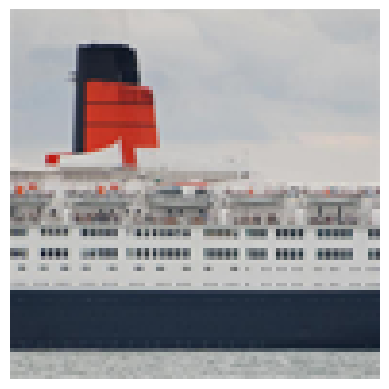

In [13]:
import numpy as np
import matplotlib.pyplot as plt

indice = 25 
sample_image = data_train.data[indice] 
sample_image = np.transpose(sample_image, (1, 2, 0))

# 📌 Mostrar la imagen
plt.imshow(sample_image)
plt.axis("off")
plt.show()

In [14]:
data_train.data[25].shape

(3, 96, 96)

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataset, train=True):
        self.dataset = dataset

        if train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),  # gir horizontla con .5 de p
                transforms.RandomRotation(15),  # rotar aleatorio ±15°
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),  # variar color
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # traslación y escalado
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # estandarizar
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # estandarizar
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image) 

        return image, label

In [41]:
dataset_train = ImageDataset(data_train)
dataset_test = ImageDataset(data_test)
dataset_val = ImageDataset(data_val)

print(f"Tamaño set de entrenamiento: {len(dataset_train)}")
print(f"Tamaño set de validación:    {len(dataset_val)}")
print(f"Tamaño set de test:        {len(dataset_test)}")

Tamaño set de entrenamiento: 5000
Tamaño set de validación:    4000
Tamaño set de test:        4000


In [42]:
idx = 200
img, lbl = dataset_train[idx]
print(f"Tipo de dato imagen: {type(img)}")
print(f"Máximo/mínimo imagen: {img.min()}/{img.max()}")
print(f"Tamaño imagen: {img.size()}")
print(f"Etiqueta imagen: {lbl}")

Tipo de dato imagen: <class 'torch.Tensor'>
Máximo/mínimo imagen: -1.0/1.0
Tamaño imagen: torch.Size([3, 96, 96])
Etiqueta imagen: 0


### Train model

In [43]:
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

In [44]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando la GPU")
else:
    device = torch.device("cpu")
    print("Usando la CPU")

Usando la GPU


In [45]:
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim

torch.manual_seed(35)

# 1. importar ResNet
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
num_features = model.fc.in_features
num_features

2048

In [47]:
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10)
)



In [48]:
EPOCHS = 15
lr = 0.001
l2 = 1e-3
BATCH_SIZE = 64
perdida = nn.CrossEntropyLoss()
optimizador = optim.AdamW(model.parameters(), lr=lr)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
def train_nn(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    total_loss = 0
    model.train()
    model.to(device)

    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    print(f"train_loss: {total_loss:>8f}")
    return total_loss


def validate_nn(dataloader, model, loss_fn, device):
    model.eval()
    model.to(device)                  
    size = len(dataloader.dataset) 
    n_lotes = len(dataloader)      
    total_loss, aciertos = 0, 0 

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            total_loss += loss_fn(pred, y).item()
            aciertos += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss = total_loss/n_lotes
    aciertos /= size
    print(f"val_loss: {val_loss:>8f}")
    print(f"Error validación (Accuracy): {(100*aciertos):>0.1f}")

    return val_loss

In [50]:
train_losses = []
val_losses = []
print(f"Training for {EPOCHS} Epochs using {device}")
print(f"\n")
for t in range(EPOCHS):
    print(f"Epoch {t+1}/{EPOCHS}\n")
    train_loss = train_nn(dataloader_train, model, perdida, optimizador, device)
    val_loss = validate_nn(dataloader_val, model, perdida, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"-------------------------------\n")

Training for 15 Epochs using cuda


Epoch 1/15

train_loss: 1.357066
val_loss: 2.266643
Error validación (Accuracy): 44.1
-------------------------------

Epoch 2/15

train_loss: 1.030664
val_loss: 1.044144
Error validación (Accuracy): 65.2
-------------------------------

Epoch 3/15

train_loss: 0.944688
val_loss: 1.238847
Error validación (Accuracy): 60.8
-------------------------------

Epoch 4/15

train_loss: 0.957796
val_loss: 1.009648
Error validación (Accuracy): 65.6
-------------------------------

Epoch 5/15

train_loss: 0.792368
val_loss: 1.090027
Error validación (Accuracy): 66.4
-------------------------------

Epoch 6/15

train_loss: 0.831671
val_loss: 0.915543
Error validación (Accuracy): 68.5
-------------------------------

Epoch 7/15

train_loss: 0.681167
val_loss: 0.720314
Error validación (Accuracy): 75.2
-------------------------------

Epoch 8/15

train_loss: 0.626497
val_loss: 0.846756
Error validación (Accuracy): 71.2
-------------------------------

Epoch 9/15



### Eval model

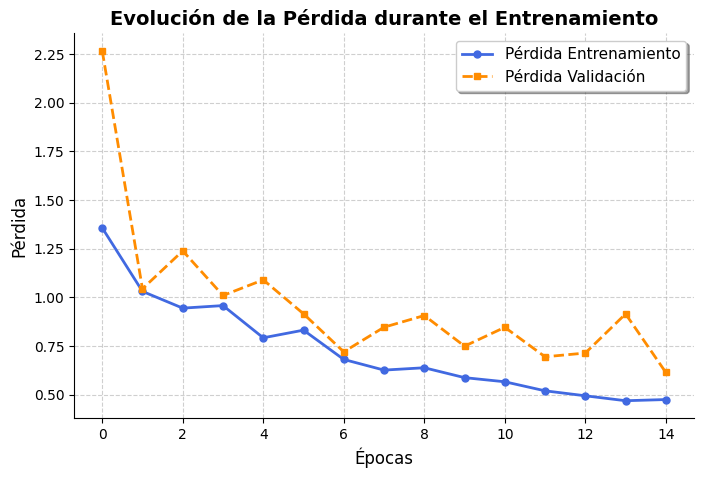

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(train_losses, label='Pérdida Entrenamiento', color='royalblue', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Pérdida Validación', color='darkorange', linewidth=2, linestyle='--', marker='s', markersize=5)

plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.title('Evolución de la Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')

plt.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

In [52]:
def calcular_acc(model, dataloader, device):
    model.eval()
    aciertos = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            aciertos += (preds.argmax(1) == y).type(torch.float).sum().item()
    exactitud = aciertos / len(dataloader.dataset)
    return exactitud

In [53]:
acc_train = calcular_acc(model, dataloader_train, device)
acc_val = calcular_acc(model, dataloader_val, device)
acc_test = calcular_acc(model, dataloader_test, device)

print(f"Accuracy Train {100*acc_train:.6f}%")
print(f"Accuracy val {100*acc_val:.6f}%")
print(f"Accuracy Test {100*acc_test:.6f}%")

Accuracy Train 87.540000%
Accuracy val 80.075000%
Accuracy Test 79.200000%
